#  1. IMPORTING LIBRARIES

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)



# Models

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#  LOAD DATA

In [ ]:
df = pd.read_csv("mushrooms.csv")
 
print(df.shape)
print(df.info()) 

(8124, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-a

In [7]:
print(df.head())

  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1       

#  DATA CLEANING

In [8]:
# Check for duplicates
print("Duplicate rows:", df.duplicated().sum())

# Check for null values
print("Null values:\n", df.isnull().sum())

Duplicate rows: 0
Null values:
 class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64


#   EDA: FEATURE DISTRIBUTION

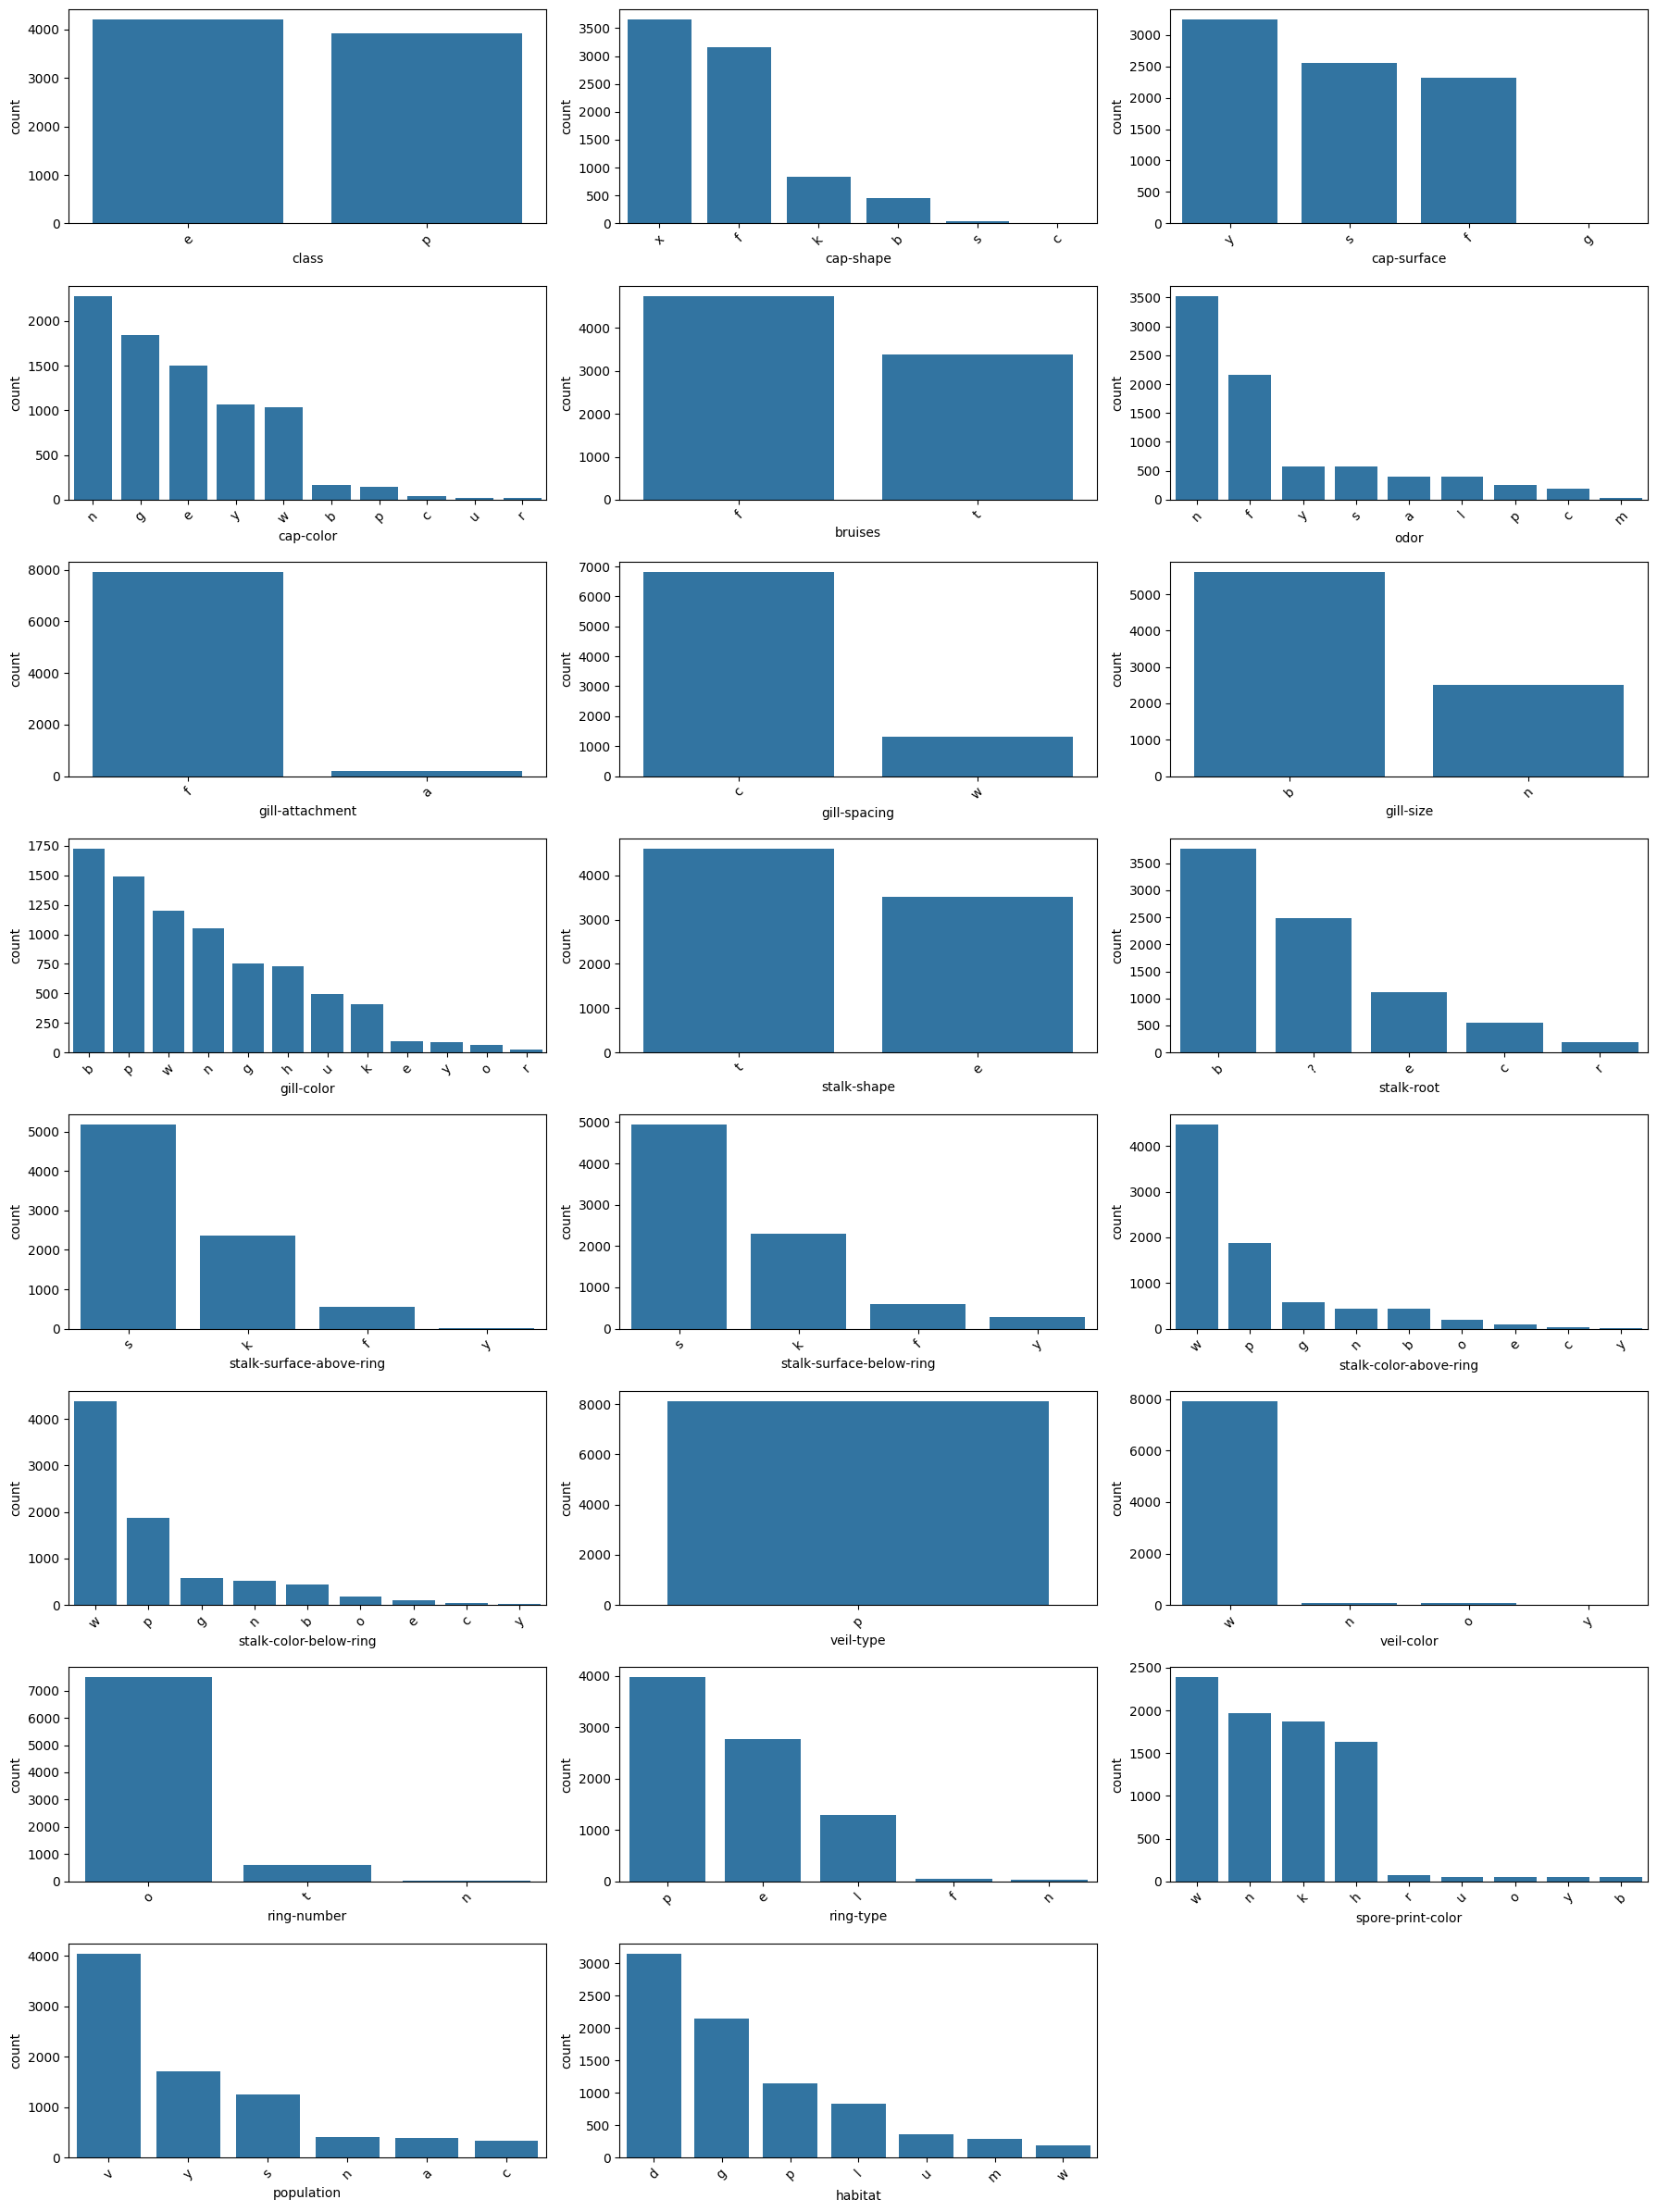

In [10]:
 # Countplot for each categorical feature
fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(18, 24))
for index, col in enumerate(df.columns):
    row, col_num = divmod(index, 3)
    sns.countplot(data=df, x=col, ax=axes[row][col_num], order=df[col].value_counts().index)
    axes[row][col_num].tick_params(axis='x', rotation=45)
fig.delaxes(axes[7][2])  # Remove empty subplot
plt.tight_layout()
plt.show()


# Output class  

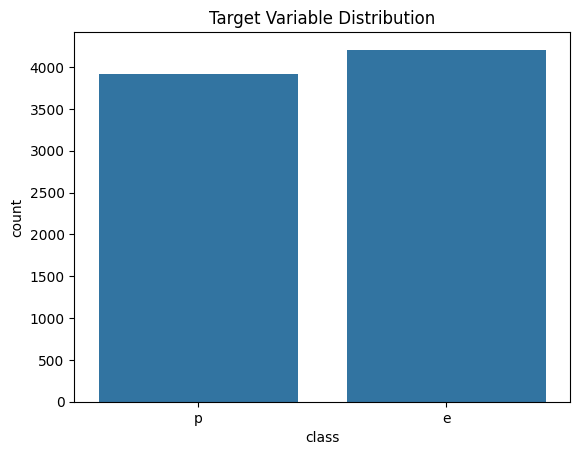

In [12]:
sns.countplot(x="class", data=df)
plt.title("Target Variable Distribution")
plt.show()

#  CATEGORICAL CORRELATION - CRAMÉR’S V

In [13]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

correlations = {}
for col in df.columns:
    if col != 'class':
        correlations[col] = cramers_v(df[col], df['class'])

cramer_df = pd.DataFrame.from_dict(correlations, orient='index', columns=["Cramér's V"])
cramer_df = cramer_df.sort_values(by="Cramér's V", ascending=False)
print(cramer_df)


                          Cramér's V
odor                        0.970558
spore-print-color           0.752036
gill-color                  0.679877
ring-type                   0.602900
stalk-surface-above-ring    0.587666
stalk-surface-below-ring    0.574551
gill-size                   0.539677
stalk-color-above-ring      0.523943
stalk-color-below-ring      0.513799
bruises                     0.501188
population                  0.486775
habitat                     0.439323
stalk-root                  0.406224
gill-spacing                0.347897
cap-shape                   0.244330
cap-color                   0.215889
ring-number                 0.214212
cap-surface                 0.195997
veil-color                  0.152222
gill-attachment             0.127951
stalk-shape                 0.101170
veil-type                        NaN


C:\Users\Hemanth2512005\AppData\Local\Temp\ipykernel_5156\227163133.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


#  ENCODING

In [14]:
# Convert categorical variables to dummy variables
X = pd.get_dummies(df.drop('class', axis=1))

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(df['class'])


# Train- test  and Scaling 

In [15]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#   LOGISTIC REGRESSION

Logistic Regression Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1257
           1       1.00      1.00      1.00      1181

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



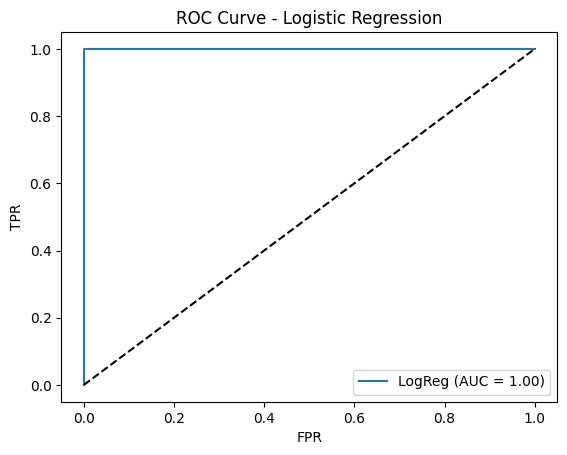

In [16]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.plot(fpr, tpr, label=f'LogReg (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()


# Logistic Regression Training and Testing Accuracy

In [ ]:
# to check overfitting 
#  
y_train_pred_lr = lr.predict(X_train_scaled)
y_test_pred_lr = lr.predict(X_test_scaled)

print("🔹 Logistic Regression")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_lr):.4f}")
print(f"Testing Accuracy : {accuracy_score(y_test, y_test_pred_lr):.4f}\n")


🔹 Logistic Regression
Training Accuracy: 1.0000
Testing Accuracy : 1.0000



# Confusion Matrix 

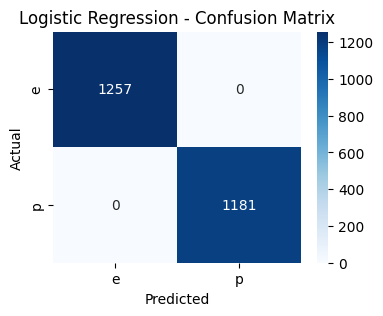

In [18]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_test_pred_lr)

plt.figure(figsize=(4,3))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# DECISION TREE

Decision Tree Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1257
           1       1.00      1.00      1.00      1181

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



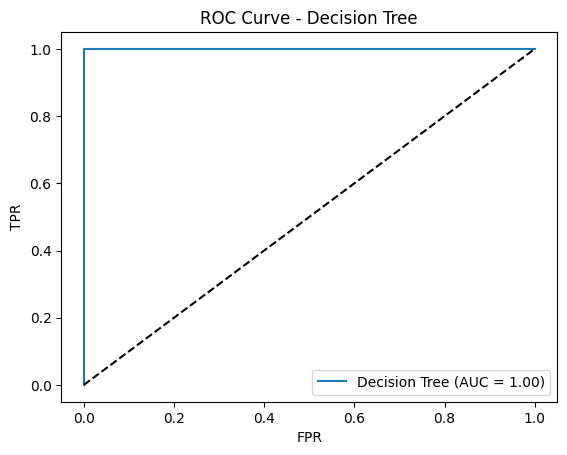

In [17]:
 
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_dt)
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {roc_auc_score(y_test, y_prob_dt):.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve - Decision Tree')
plt.legend()
plt.show()

# Visualize Tree

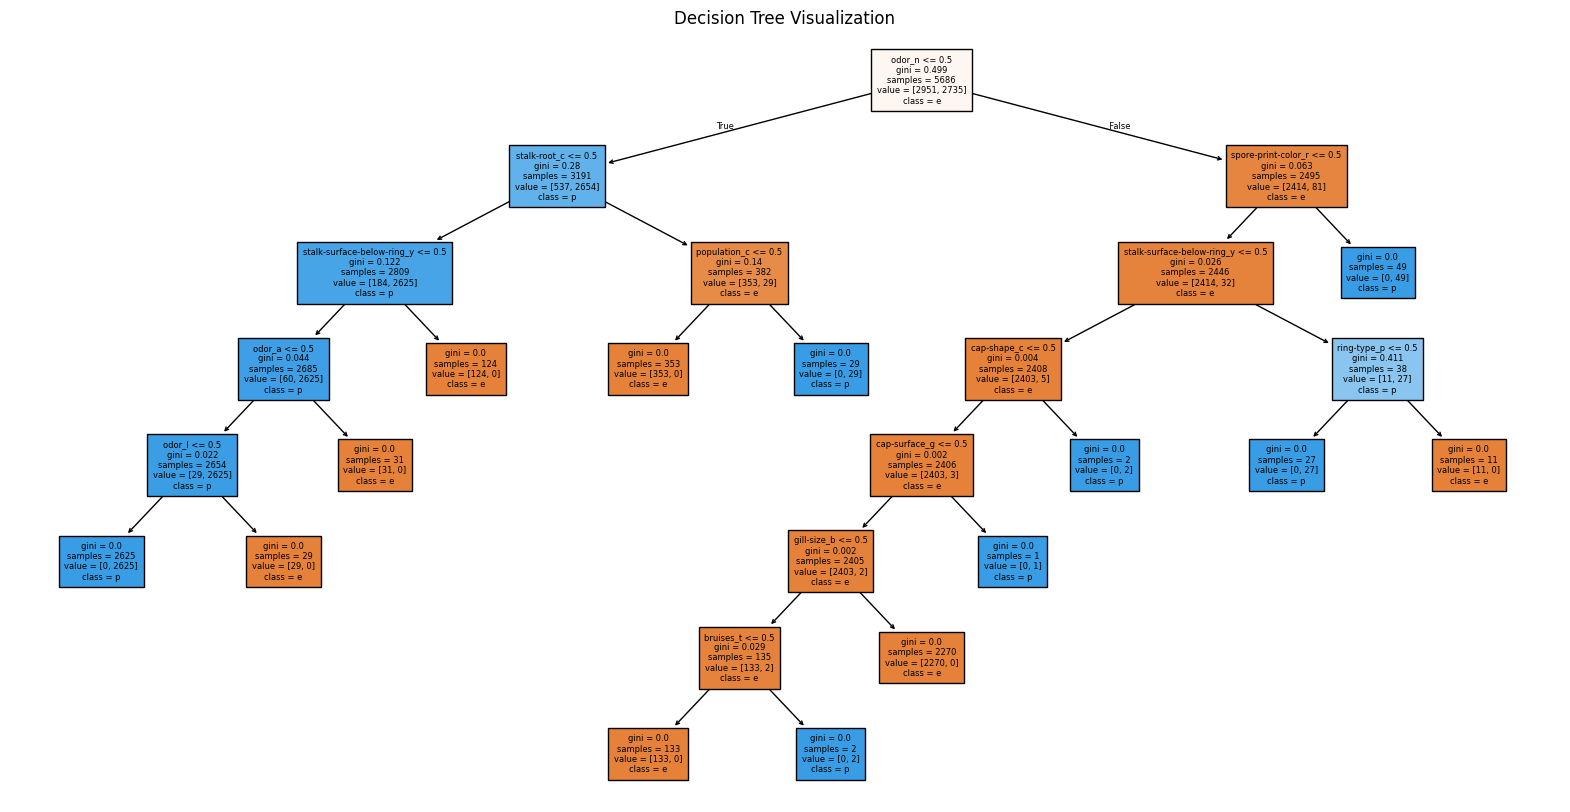

In [18]:
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X.columns, class_names=le.classes_, filled=True, fontsize=6)
plt.title("Decision Tree Visualization")
plt.show()


# Decision Tree Training and Testing Accuracy

In [20]:
y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)

print("🔹 Decision Tree")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_dt):.4f}")
print(f"Testing Accuracy : {accuracy_score(y_test, y_test_pred_dt):.4f}\n")


🔹 Decision Tree
Training Accuracy: 1.0000
Testing Accuracy : 1.0000



# Confusion Matrix 

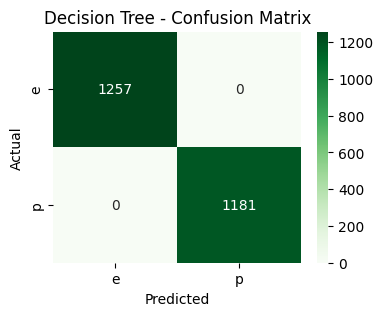

In [21]:
cm_dt = confusion_matrix(y_test, y_test_pred_dt)

plt.figure(figsize=(4,3))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Decision Tree - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#  K-NEAREST NEIGHBORS (KNN)

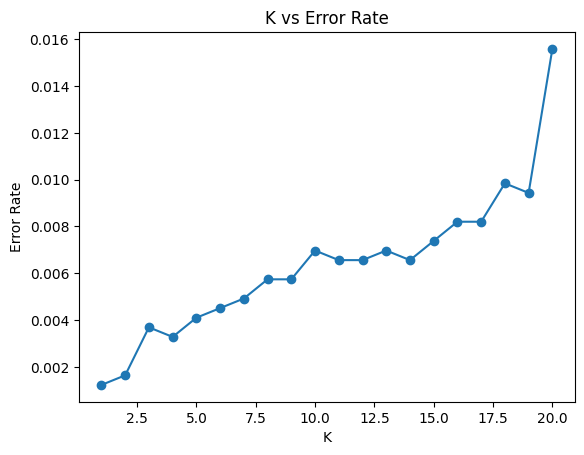

KNN Accuracy: 0.9987694831829368
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1257
           1       1.00      1.00      1.00      1181

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



In [22]:
 
X_encoded = df.drop('class', axis=1).apply(LabelEncoder().fit_transform)
y_encoded = LabelEncoder().fit_transform(df['class'])

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)

# Find optimal k
error_rate = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_knn, y_train_knn)
    pred = knn.predict(X_test_knn)
    error_rate.append(np.mean(pred != y_test_knn))

plt.plot(range(1,21), error_rate, marker='o')
plt.title('K vs Error Rate')
plt.xlabel('K'); plt.ylabel('Error Rate')
plt.show()

# Final model
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_knn, y_train_knn)
y_pred_knn = knn.predict(X_test_knn)

print("KNN Accuracy:", accuracy_score(y_test_knn, y_pred_knn))
print(classification_report(y_test_knn, y_pred_knn))


# KNN Training and Testing Accuracy

In [23]:
 
y_train_pred_knn = knn.predict(X_train_knn)
y_test_pred_knn = knn.predict(X_test_knn)

print("🔹 K-Nearest Neighbors (k=1)")
print(f"Training Accuracy: {accuracy_score(y_train_knn, y_train_pred_knn):.4f}")
print(f"Testing Accuracy : {accuracy_score(y_test_knn, y_test_pred_knn):.4f}\n")


🔹 K-Nearest Neighbors (k=1)
Training Accuracy: 1.0000
Testing Accuracy : 0.9988



# Confusion Matrix 

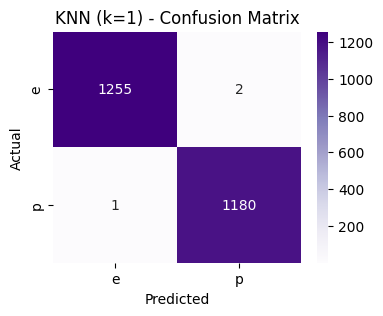

In [24]:
cm_knn = confusion_matrix(y_test_knn, y_test_pred_knn)

plt.figure(figsize=(4,3))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Purples', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('KNN (k=1) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#  SUPPORT VECTOR MACHINE (SVM)

SVM Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1257
           1       1.00      1.00      1.00      1181

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



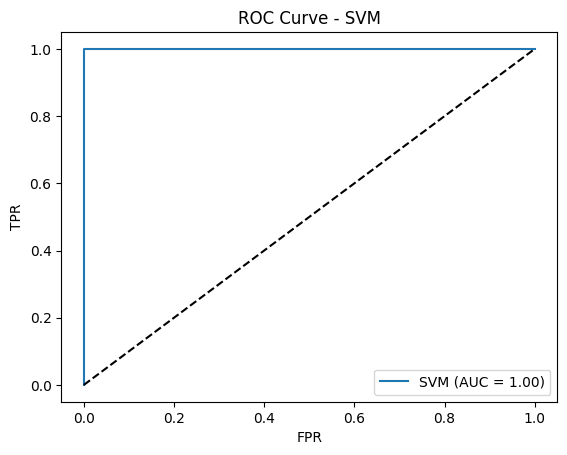

In [25]:
 
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
y_prob_svm = svm.predict_proba(X_test_scaled)[:, 1]

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_svm)
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc_score(y_test, y_prob_svm):.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve - SVM')
plt.legend()
plt.show()


# SVM Training and Testing Accuracy

In [26]:
 
y_train_pred_svm = svm.predict(X_train_scaled)
y_test_pred_svm = svm.predict(X_test_scaled)

print("🔹 Support Vector Machine")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_svm):.4f}")
print(f"Testing Accuracy : {accuracy_score(y_test, y_test_pred_svm):.4f}\n")


🔹 Support Vector Machine
Training Accuracy: 1.0000
Testing Accuracy : 1.0000



# Confusion Matrix 

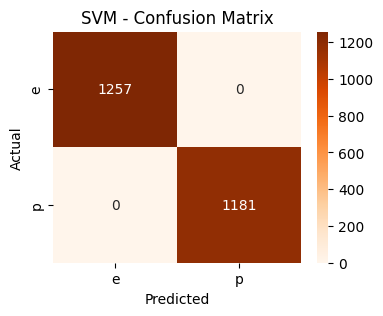

In [27]:
cm_svm = confusion_matrix(y_test, y_test_pred_svm)

plt.figure(figsize=(4,3))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('SVM - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [28]:
#  Use Logistic Regression if:
# speed, simplicity, and interpretability
# You're deploying to mobile/web/embedded systems
# # You want probability outputs 

In [29]:
import pickle

# Save model
with open("logistic_model.pkl", "wb") as f:
    pickle.dump(lr, f)

# Save scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save feature column names
with open("feature_columns.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)
